## Task 2

Q: Repeat the same tasks with the digits dataset (sklearn.datasets.load_digits()). Use the models and algorithms from sklearn this time. You may consider sklearn's KDtrees for speeding up computations in GMMs and KDE. Replace histograms (which do not scale to higher dimensions) with density forests, e.g. using the code from https://pypi.org/project/quantile-forest/ or https://github.com/ kfritsch/density_forest. Again, check model accuracy by MMD and visualize generated data for some representative models (you do not need to visualize the numerical density values this is hard in 64 dimensions). In addition, train a sklearn.ensemble.RandomForestClassifier on the original dataset to distinguish the 10 digit classes. Use this classi er to check for the models which create recognisable output if the 10 digits are generated in equal proportions.

MMD for Histogram model: 0.0041
MMD for Gaussian model: 0.0016
MMD for GMM model: 0.00156
MMD for KDE model: 0.00156
Approximate recognizability accuracy for 2D Histogram: 0.1000
Approximate recognizability accuracy for Single Gaussian: 0.1070
Approximate recognizability accuracy for GMM: 0.0990
Approximate recognizability accuracy for KDE: 0.0900


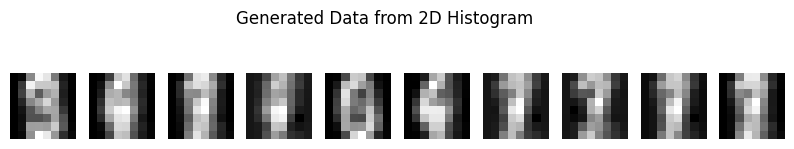

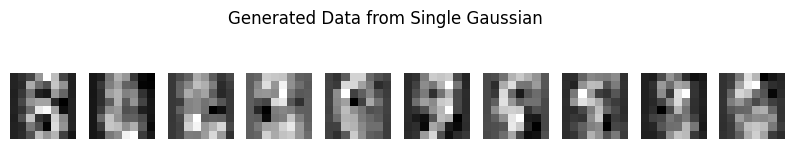

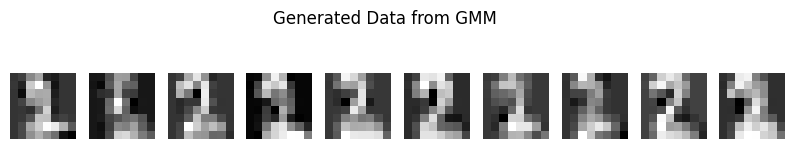

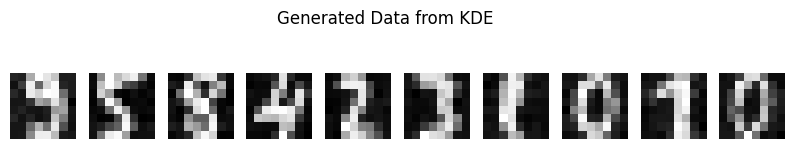

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

# Load the digits dataset
digits = load_digits()
x_digits, y_digits = digits.data, digits.target

# Reduce dimensionality to 2 from 64 for 2-D histogram
pca = PCA(n_components=2)
x_digits_2d = pca.fit_transform(x_digits)


# Define histogram bin size as a hyperparameter
def fit_2d_histogram(x, bin_size):
    hist, edges = np.histogramdd(x, bins=[bin_size] * x.shape[1], density=True)
    return hist, edges

def generate_histogram_samples(histogram, edges, n_samples):
    dim = histogram.ndim
    samples = []

    # Normalize the histogram to get probabilities
    histogram_probs = histogram / histogram.sum()

    for _ in range(n_samples):
        sample = []
        for d in range(dim):
            # Marginalize histogram along all other dimensions
            marginal_probs = histogram_probs.sum(axis=tuple(i for i in range(dim) if i != d))

            # Normalize marginal probabilities to sum to 1
            marginal_probs /= marginal_probs.sum()

            # Choose a bin based on the marginal probabilities
            bin_idx = np.random.choice(len(edges[d]) - 1, p=marginal_probs)

            # Sample uniformly within the chosen bin
            sample.append(np.random.uniform(edges[d][bin_idx], edges[d][bin_idx + 1]))

        samples.append(sample)
    return np.array(samples)


# histogram with bin size
histogram, edges = fit_2d_histogram(x_digits_2d, bin_size=10)

# Evaluate MMD for histogram model
generated_histogram_data_2d = generate_histogram_samples(histogram, edges, n_samples=1000)
# Map 2D samples back to the original 64D space using the inverse PCA transform
generated_histogram_data_64d = pca.inverse_transform(generated_histogram_data_2d)

# Single Gaussian
mean = np.mean(x_digits, axis=0)
covariance = np.cov(x_digits, rowvar=False)

def generate_gaussian_samples(mean, covariance, n_samples):
    return np.random.multivariate_normal(mean, covariance, n_samples)


# data from single Gaussian model
generated_data_gaussian = generate_gaussian_samples(mean, covariance, n_samples=1000)


# Function to compute MMD using squared exponential kernel
def squared_exponential_kernel(data1, data2, sigma=1.0):
    return np.exp(-cdist(data1, data2, 'sqeuclidean') / (2 * sigma ** 2))

def mmd(data1, data2, kernel_func):
    K11 = kernel_func(data1, data1).mean()
    K22 = kernel_func(data2, data2).mean()
    K12 = kernel_func(data1, data2).mean()
    return K11 + K22 - 2 * K12

# Fit GMM with n_components
def fit_gmm(data, n_components):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data)
    return gmm

# Fit KDE with bandwidth
def fit_kde(data, bandwidth):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data)
    return kde

# Generate samples from GMM
def sample_from_gmm(gmm, n_samples):
    return gmm.sample(n_samples)[0]

# Generate samples from KDE
def sample_from_kde(kde, n_samples):
    samples = kde.sample(n_samples)
    return samples

# Fit GMM and KDE to the original data
gmm = fit_gmm(x_digits, n_components=10)
kde = fit_kde(x_digits, bandwidth=0.5)

# Generate samples from GMM and KDE
generated_data_gmm = sample_from_gmm(gmm, n_samples=1000)
generated_data_kde = sample_from_kde(kde, n_samples=1000)

# MMD evaluations
mmd_histogram = mmd(x_digits, generated_histogram_data_64d, squared_exponential_kernel)
mmd_gaussian = mmd(x_digits, generated_data_gaussian, squared_exponential_kernel)
mmd_gmm = mmd(x_digits, generated_data_gmm, squared_exponential_kernel)
mmd_kde = mmd(x_digits, generated_data_kde, squared_exponential_kernel)

print(f"MMD for Histogram model: {mmd_histogram:.4f}")
print(f"MMD for Gaussian model: {mmd_gaussian:.4f}")
print(f"MMD for GMM model: {mmd_gmm:.5f}")
print(f"MMD for KDE model: {mmd_kde:.5f}")


# Train Random Forest Classifier on the dataset
x_train, x_test, y_train, y_test = train_test_split(x_digits, y_digits, train_size=0.75, random_state=0)

def train_random_forest(X, y):
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X, y)
    return clf

# Train a RandomForestClassifier on the original dataset
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(x_train, y_train)

# Evaluate accuracy of generated samples
def evaluate(model_name, generated_data):
    labels_pred = rf_classifier.predict(generated_data)
    accuracy = accuracy_score(y_digits[:len(labels_pred)], labels_pred)
    print(f"Approximate recognizability accuracy for {model_name}: {accuracy:.4f}")

# Evaluate the recognizability of generated data
evaluate("2D Histogram", generated_histogram_data_64d)
evaluate("Single Gaussian", generated_data_gaussian)
evaluate("GMM", generated_data_gmm)
evaluate("KDE", generated_data_kde)


# To plot generated samples
def plot_generated_digits(data, title="Generated Data"):
    n = min(10, data.shape[0])
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(data[i].reshape(8, 8), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

plot_generated_digits(generated_histogram_data_64d, "Generated Data from 2D Histogram")
plot_generated_digits(generated_data_gaussian, "Generated Data from Single Gaussian")
plot_generated_digits(generated_data_gmm, "Generated Data from GMM")
plot_generated_digits(generated_data_kde, "Generated Data from KDE")
